# Using s_first during r vine copula (vinecop) fitting

The tpl_first given during fitting will become the last elements in the sampling order of the fitted vine. By giving this information, we bipartite indices into two sets Y|X, where X is the central part of the tree at lv0, Y is the peripheral part.

Equivalently, the fitted vine allows for conditional simulation Y←X.

This guidance may improve fitted model AIC on average.


In [1]:
import sys
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

# * add proj root folder into path
sys.path.append("..")
import torchvinecopulib as tvc

print(f"cuda (GPU) avail? {torch.cuda.is_available()}\n")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_SIM, num_dim, seed = 1000, 10, 42
NUM_FOLD_STRUCT = 5

cuda (GPU) avail? True



In [2]:
dct_aic = defaultdict(list)
for seed in range(10):
    # * simulate a vinecop true model and simulate data
    tvc_mdl_true = tvc.vinecop.vcp_from_sim(num_dim=num_dim, seed=seed)
    V_mvcp_true = tvc_mdl_true.sim(num_sim=NUM_SIM, device=DEVICE, seed=seed)
    # * cross validation
    vec_idx = np.random.permutation(V_mvcp_true.shape[0])
    for idx_fold, idx_test in enumerate(np.array_split(vec_idx, NUM_FOLD_STRUCT)):
        idx_train = np.setdiff1d(vec_idx, idx_test)
        for len_tpl_first in range(num_dim):
            # * prepare tpl_first to guide fitting with partial sampling order from true model
            tpl_first = tvc_mdl_true.tpl_sim[-len_tpl_first:]
            tvc_mdl_fit = tvc.vinecop.vcp_from_obs(
                obs_mvcp=V_mvcp_true[idx_train, :],
                tpl_first=tpl_first,
                mtd_vine="rvine",
                mtd_bidep="kendall_tau",
            )
            dct_aic[len_tpl_first].append(
                2.0
                * (tvc_mdl_fit.num_par - tvc_mdl_fit.l_pdf(V_mvcp_true[idx_test, :]).sum().item())
            )

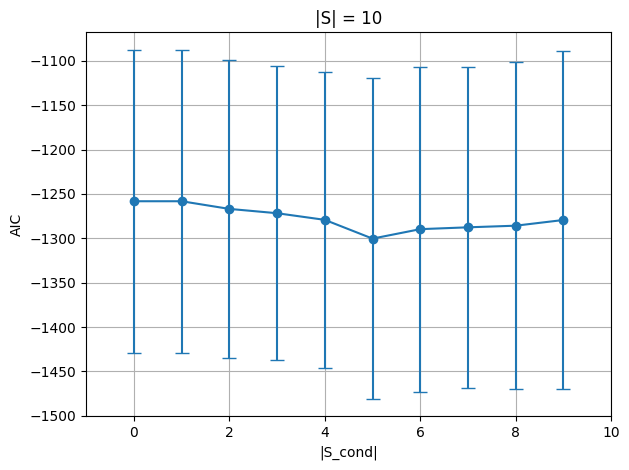

In [3]:
df_aic = pd.DataFrame(dct_aic)
fig, ax = plt.subplots()
ax.errorbar(
    df_aic.columns,
    df_aic.mean(axis=0),
    yerr=df_aic.std(axis=0),
    fmt="o",
    linestyle="-",
    capsize=5,
)
ax.set_xlim(-1, num_dim)
ax.grid()
ax.set_title(f"""|S| = {num_dim}""")
ax.set_xlabel("|S_cond|")
ax.set_ylabel("AIC")
plt.tight_layout()